## CEE 266F Final Project: Marilyn Frank, Jorge Meraz, Nate Ramos

In [1]:
# %% Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

from math import gamma as GammaFN
import scipy.stats as ss
from scipy.optimize import brentq as root
from scipy.optimize import fsolve
import math
from IPython.display import Image

import scipy.signal
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA

## Function Definitions

In [2]:
# Function to find moments of data
def findMoments(data):
    xbar = np.mean(data)
    std = np.std(data, ddof=1)
    skew = ss.skew(data, bias=False)

    return xbar, std, skew

# Function to fit data to a normal distribution, using either MLE or MOM
def fitNormal(data, method):
    assert method == 'MLE' or method == 'MOM', "method must = 'MLE' or 'MOM'"

    xbar, std, skew = findMoments(data)

    if method == 'MLE':
        mu, sigma = ss.norm.fit(data)

    elif method == 'MOM':
        mu = xbar
        sigma = std

    return mu, sigma

# Function to make QQ plot for normal data with correlation test
def NormalPPCT(data, mu, sigma, title, figname):
    x_sorted = np.sort(data)
    p_observed = np.arange(1, len(data) + 1, 1) / (len(data) + 1)
    x_fitted = ss.norm.ppf(p_observed, mu, sigma)
    rho = np.corrcoef(x_sorted, x_fitted)[0, 1]

    plt.scatter(x_sorted, x_fitted, color='b')
    plt.plot(x_sorted, x_sorted, color='r')
    plt.xlabel('Observations')
    plt.ylabel('Fitted Values')
    plt.title(title)
    plt.savefig(figname)
    plt.clf()

    # Estimate p-value of corelation coefficient
    
    rhoVector = np.zeros(10000)
    for i in range(10000):
        x = ss.norm.rvs(mu, sigma, len(data))
        rhoVector[i] = np.corrcoef(np.sort(x), x_fitted)[0, 1]

    count = 0
    for i in range(len(rhoVector)):
        if rho < rhoVector[i]:
            count = count + 1

    p_value = 1 - count / 10000
    return rho, p_value, figname

In [3]:
def autocorr(x,k):
  '''returns the lag-k autocorrelation of vector x'''
  x = x.reshape(-1,1)
  return sm.tsa.acf(x)[1]

def thomasfiering(x, T, N):
  '''Lag-1 model. use historical data x 
  to generate N synthetic sequences of T timesteps.
  Assumes x is lognormally distributed.'''

  # Set random seed
  np.random.seed(5)

  # Log transform of data
  x = np.log(x) # log-space avoids negative values

  # Calculate mean, variance, lag-1 autocorrelation
  mu = x.mean()
  sigma = x.std()
  rho = autocorr(x,1)
  # Note the retransformation bias in rho

  # Initialize the a N x T matrix where you will save streamflow values
  Q = np.zeros([N, T])
  Q[:, 0] = np.random.normal(mu,sigma,1)  # Choose starting value

  # Loop over time, and simulate AR(1) for each
  # Note instead of looping over N, we vectorize
  for i in range(1, T):
    Z = np.random.standard_normal(N)
    Q[:, i] = mu + rho*(Q[:, i-1] - mu) + Z*sigma*np.sqrt(1-rho**2)

  return np.exp(Q) 

In [187]:
def threshold_freq(Q, threshold_lower, threshold_higher, threshold_highest, droughtLen):
  '''Count the average number of flow events that are below threshold X
    in each streamflow timeseries Q.
    Q can either be a N x T matrix or a vector with a single time series of length T'''

  # Get N and T from Q - the try except is used to handle either matrix or vector input
  try:
    T = np.shape(Q)[1]
    N = len(Q)
  except:
    N = 1
    T = len(Q)

  # If N = 1, turn vector into 2D matrix so indexing workds
  if N == 1:
    Q = Q.reshape(1, -1)

  # Initialize vector to save number of multi year droughts in each time series
  numNYrDrought = np.zeros(N)

  # Loop over each time series (could vectorize this to improve speed)
  for i in range(N):

    # Get vector for a single time series
    Q_now = Q[i,:]

    # Find which values are below the drought threshold - True means drought
    within_threshold = (threshold_lower < Q_now) & (Q_now < threshold_higher)
    above_threshold = (threshold_highest < Q_now)


  numNotMet = np.sum(within_threshold)
  numAbove = np.sum(above_threshold)


  return numNotMet,numAbove, T

## Historical Analysis at Wilkins Slough Gage, Sacramento River

In [2]:
# load data of daily flows on the Sacramento River, CA
Wilkins_dailyQ = pd.read_excel('266F Project Data.xlsx', names = ['Agency','Gage No.', 'Date', 'Flow','A'])

In [3]:
# convert first column to date
Wilkins_dailyQ['Date'] = pd.to_datetime(Wilkins_dailyQ['Date'],format="%Y-%m-%d")
Wilkins_dailyQ['Flow'] = pd.to_numeric(Wilkins_dailyQ['Flow'],errors='ignore')

# find year of each data point
Wilkins_dailyQ['Year'] = Wilkins_dailyQ['Date'].dt.year

years_unproc = np.unique(Wilkins_dailyQ['Year'])

In [6]:
years

array([1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020, 2021])

In [5]:
# convert first column to date
Wilkins_dailyQ['Date'] = pd.to_datetime(Wilkins_dailyQ['Date'],format="%Y-%m-%d")
Wilkins_dailyQ['Flow'] = pd.to_numeric(Wilkins_dailyQ['Flow'],errors='ignore')

# find year of each data point
Wilkins_dailyQ['Year'] = Wilkins_dailyQ['Date'].dt.year

years_unproc = np.unique(Wilkins_dailyQ['Year'])

# Delete leap days
Wilkins_dailyQ = Wilkins_dailyQ[~((Wilkins_dailyQ.Date.dt.month == 2) & (Wilkins_dailyQ.Date.dt.day == 29))]

# Delete first and last year if data incomplete
Wilkins_dailyQ = Wilkins_dailyQ[~(Wilkins_dailyQ['Year'] == min(years_unproc))]
Wilkins_dailyQ = Wilkins_dailyQ[~(Wilkins_dailyQ['Year'] == max(years_unproc))]
Wilkins_dailyQ = Wilkins_dailyQ[~(Wilkins_dailyQ['Year'] == 1939)]
Wilkins_dailyQ = Wilkins_dailyQ[~(Wilkins_dailyQ['Year'] == 1940)]


years = np.unique(Wilkins_dailyQ['Year'])

# Fill in a nan value
Wilkins_dailyQ = Wilkins_dailyQ.fillna(method='ffill')

# Wilkins_dailyQ = np.array(Wilkins_dailyQ['Flow'])

# Get annual flow
Wilkins_annQ = np.array(Wilkins_dailyQ.groupby('Year').mean()['Flow'])

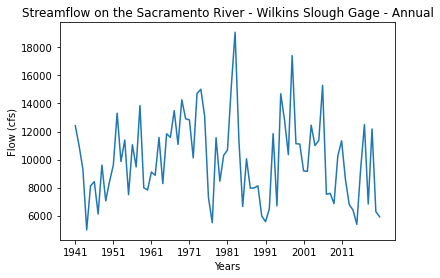

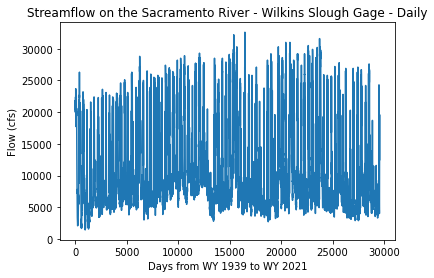

In [80]:
#  historical plots
plt.plot(years,Wilkins_annQ)
plt.xlabel('Years')
plt.xticks(np.arange(min(years), max(years), step=10))
plt.ylabel('Flow (cfs)')
plt.title('Streamflow on the Sacramento River - Wilkins Slough Gage - Annual')
plt.show()

plt.plot(range(len(Wilkins_dailyQ)),Wilkins_dailyQ['Flow'])
plt.xlabel('Days from WY 1939 to WY 2021')
plt.ylabel('Flow (cfs)')
plt.title('Streamflow on the Sacramento River - Wilkins Slough Gage - Daily')
plt.show()

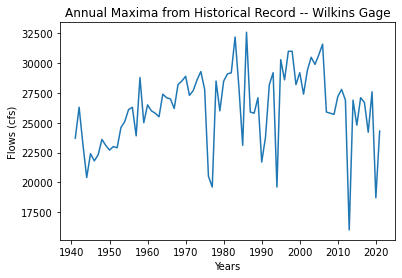

In [81]:
# Find annual maxima
maxQ = Wilkins_dailyQ.groupby('Year').max()
plt.plot(years, maxQ['Flow'])
plt.title('Annual Maxima from Historical Record -- Wilkins Gage')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.show()

In [82]:
# Historical 10Q10 
# group flow data into a list per year
Wilkins_Q_by_year = Wilkins_dailyQ.groupby('Year')['Flow'].apply(list)

Min10DayFlow = []
Yearly_Daily_Flows =[]
TenDayFlow = []

# compute annual min 10-day flows for 15 March (74th day) to 15 June (166th)
for year in years:
    Yearly_Daily_Flows = Wilkins_Q_by_year[year]
    for s in range(len(Yearly_Daily_Flows)):
        if s > 79 and s < 171:
            TenDayFlow_calc = sum(Yearly_Daily_Flows[s-11:s+1])
            TenDayFlow.append(TenDayFlow_calc) 
    Min10DayFlow.append(min(TenDayFlow))
    TenDayFlow = [] # reset list to ensure min of each year, not of multiple years
Min10DayFlow_Array = np.array(Min10DayFlow)

In [83]:
# %% Survival Threshold Defined by Michel et al.
threshold_min = 4259 * 10 # scaling 10 d moving avg for 10 day sum
threshold_mean = 10712 * 10
threshold_high = 22872 * 10
droughtLen = 1

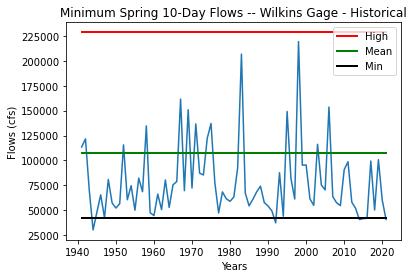

In [84]:
# Historical 10Q10 Plot
plt.figure()
plt.plot(years, Min10DayFlow_Array)
plt.title('Minimum Spring 10-Day Flows -- Wilkins Gage - Historical')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.plot([min(years),max(years)], [threshold_high, threshold_high], 'r-', lw=2, label = 'High')
plt.plot([min(years),max(years)], [threshold_mean, threshold_mean], 'g-', lw=2, label = 'Mean')
plt.plot([min(years),max(years)], [threshold_min, threshold_min], 'k-', lw=2, label = 'Min')
plt.legend()
plt.show()

In [237]:
# not met = being below
numNotMet_min, numAbove_min, T = threshold_freq(Min10DayFlow_Array, 0, threshold_min, 0, droughtLen)
print('The historical record (a {} year period) does not surpass the minimum flow threshold associated with Chinook salmon survival in the Sacramento River ({:.0f} cfs) {} times.'.format(T, threshold_min, numNotMet_min))

numNotMet_mean, numAbove_mean, T = threshold_freq(Min10DayFlow_Array, threshold_min, threshold_mean, 0, droughtLen)
print('\nThe historical record (a {} year period) lies within the minimum and historical mean functional flow thresholds associated with Chinook salmon survival in the Sacramento River ({:.0f} and {:.0f} cfs) {} times.'.format(T, threshold_min, threshold_mean, numNotMet_mean))

numNotMet_high, numAbove_high, T = threshold_freq(Min10DayFlow_Array, threshold_mean, threshold_high, 0, droughtLen)
print('\nThe historical record (a {} year period) lies within the historical mean and the high functional flow threshold associated with Chinook salmon survival in the Sacramento River ({:.0f} and {:.0f} cfs) {} times.'.format(T, threshold_mean, threshold_high, numNotMet_high))

numNotMet_highest, numAbove, T = threshold_freq(Min10DayFlow_Array, 0, 0, threshold_high, droughtLen)
print('\nThe historical record (a {} year period) lies above the high functional flow threshold associated with Chinook salmon survival in the Sacramento River ({:.0f} cfs) {} times.'.format(T, threshold_high, numAbove))


The historical record (a 81 year period) does not surpass the minimum flow threshold associated with Chinook salmon survival in the Sacramento River (42590 cfs) 7 times.

The historical record (a 81 year period) lies within the minimum and historical mean functional flow thresholds associated with Chinook salmon survival in the Sacramento River (42590 and 107120 cfs) 60 times.

The historical record (a 81 year period) lies within the historical mean and the high functional flow threshold associated with Chinook salmon survival in the Sacramento River (107120 and 228720 cfs) 14 times.

The historical record (a 81 year period) lies above the high functional flow threshold associated with Chinook salmon survival in the Sacramento River (228720 cfs) 0 times.


## Synthetic Analysis using K-nn

In [86]:
# Test for the distribution annual flow data
plt.figure()
mu, sigma = fitNormal(Wilkins_annQ,'MOM')
rho_norm_m, p_value_norm_m, qq_1 = NormalPPCT(Wilkins_annQ, mu, sigma, 'Normal PPCT', 'NormalPPCT.png')
# log transformation; tests significance of correlation coefficient; if low p -alue, reject H0 that data is from this distribution
mu, sigma = fitNormal(np.log(Wilkins_annQ),'MOM')
rho_log_m, p_value_log_m, qq_2 = NormalPPCT(np.log(Wilkins_annQ), mu, sigma, 'Log Normal PPCT', 'LogNormalPPCT.png')
# Box Cox transformation
BC_Wilkins_Q_ann, llambda = ss.boxcox(Wilkins_annQ)
mu_bc, sigma_bc = fitNormal(BC_Wilkins_Q_ann,'MOM')
rho_bc_m, p_value_bc_m, qq_3 = NormalPPCT(BC_Wilkins_Q_ann, mu_bc, sigma_bc, 'BC Normal PPCT', 'BCNormalPPCT.png')
print('Normal Distribution parameter estimates:',round(rho_norm_m, 4), round(p_value_norm_m, 4))
print('Lognormal Transformation parameter estimates:',round(rho_log_m, 3), round(p_value_log_m, 4))
print('Box Cox Transformation parameter estimates:',round(rho_bc_m, 4), round(p_value_bc_m, 4))

Normal Distribution parameter estimates: 0.9872 0.1252
Lognormal Transformation parameter estimates: 0.995 0.7583
Box Cox Transformation parameter estimates: 0.9961 0.8421


<Figure size 432x288 with 0 Axes>

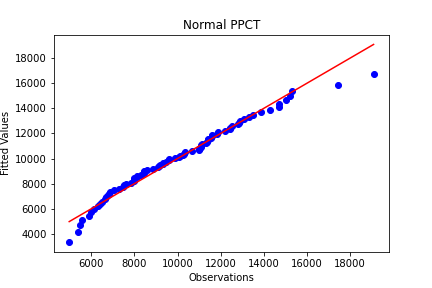

In [87]:
Image(filename='NormalPPCT.png')

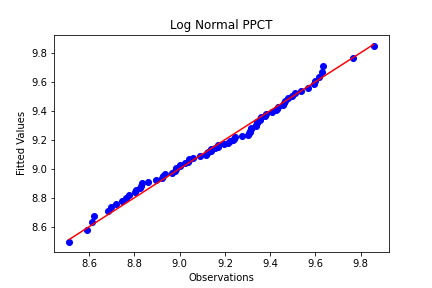

In [88]:
Image(filename='LogNormalPPCT.png') 

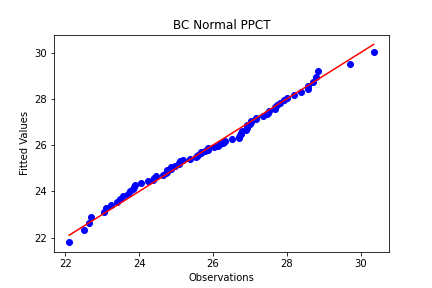

In [89]:
Image(filename='BCNormalPPCT.png')

In [90]:
# %% Use Thomas Fiering to simulate an annual flow time series based on historical annual flow
# 1 realization
# assuming a normal distribution, no data transformation
annQsyn_1 = thomasfiering(Wilkins_annQ, T=200, N=1)
annQsyn_1 = annQsyn_1[0]

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


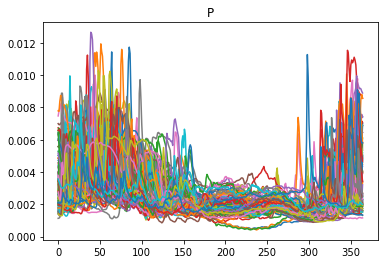

In [91]:
# %% Now start daily disaggregation using K-nn

# Calculate daily proportion matrix P from historical data

# Reshape daily data into matrix
dailyQMatrix = np.array(Wilkins_dailyQ['Flow']).reshape(-1, 365)

# Calculate annual sum i.e. sum of each row
annSum = np.sum(dailyQMatrix, 1)

# Normalize daily values by annual value
P = dailyQMatrix / annSum[:, None]

# Check that daily values sum to one
tol = .0001
assert np.sum(np.abs(np.sum(P, 1) - 1) > tol) == 0, 'rows should sum to 1'

plt.figure()
plt.plot(P.T)
plt.title('P')
plt.show()

In [92]:
# %% Resample using k nearest neighbors

# Get number of years in synthetic series
N = len(annQsyn_1)
# Choose K as sqrt of N following Lall and Sharma 1996
k = np.int(np.sqrt(N))

# Initialize
dailyQResampled = np.zeros([N, 365])

for i in range(N):

    # For the current synthetic value, find the indicies of the
    # k nearest neighbors in the historical record
    kNN_ind = np.argsort(np.abs(annQsyn_1[i] - Wilkins_annQ))[0:k]

    # Calculate the weights and check they sum to 1
    W = [(1/i) / np.sum(1 / np.arange(1,k+1)) for i in np.arange(1,k+1)]
    assert round(np.sum(W), 3) == 1.0, 'weights should sum to about 1'

    # Sample a year from historical record with weights W
    cumW = np.cumsum(W)
    rnd = np.random.rand()
    samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

    # Get daily proportion series from sampled year and use to disaggregate
    # annual synthetic flow to daily flow
    dailyQResampled[i,:] = annQsyn_1[i] * P[samp_ind, :] * 365

<ipython-input-92-312feae4d151>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N))


In [354]:
len(years)

81

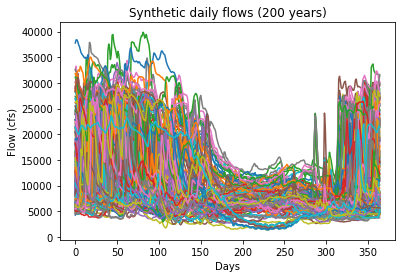

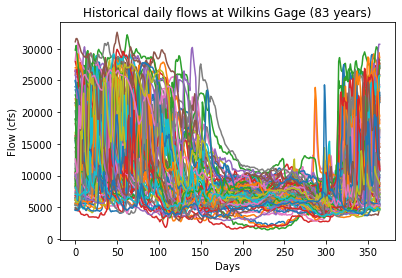

In [94]:
# %% Plot synthetic daily flows

plt.figure()
plt.plot(dailyQResampled.T)
plt.title('Synthetic daily flows (200 years)')
plt.xlabel('Days')
plt.ylabel('Flow (cfs)')
plt.show()

plt.figure()
plt.plot(dailyQMatrix.T)
plt.title('Historical daily flows at Wilkins Gage (83 years)')
plt.xlabel('Days')
plt.ylabel('Flow (cfs)')
plt.show()

# plt.savefig('KNNdisaggregation.png')

In [95]:
# Synthetic 10Q10 

# group flow data into a list per year
df_dailyQResampled = pd.DataFrame({'Daily_Flows_by_Year':list(dailyQResampled)})

years_syn = np.arange(len(annQsyn_1))

Min10DayFlow = []
Yearly_Daily_Flows =[]
TenDayFlow = []

# compute annual min 10-day flows for 15 March (74th day) to 15 June (166th)
for year in years_syn:
    Yearly_Daily_Flows = df_dailyQResampled['Daily_Flows_by_Year'][year]
    for s in range(len(Yearly_Daily_Flows)):
        if s > 79 and s < 171:
            TenDayFlow_calc = sum(Yearly_Daily_Flows[s-11:s+1])
            TenDayFlow.append(TenDayFlow_calc) 
    Min10DayFlow.append(min(TenDayFlow))
    TenDayFlow = [] # reset list to ensure min of each year, not of multiple years
Min10DayFlowSyn_Array = np.array(Min10DayFlow)

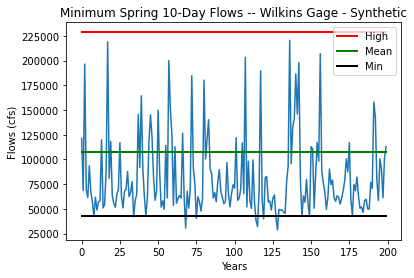

In [96]:
# Syn 10Q10 Plot
plt.figure()
plt.plot(years_syn, Min10DayFlowSyn_Array)
plt.title('Minimum Spring 10-Day Flows -- Wilkins Gage - Synthetic')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.plot([min(years_syn),max(years_syn)], [threshold_high, threshold_high], 'r-', lw=2, label = 'High')
plt.plot([min(years_syn),max(years_syn)], [threshold_mean, threshold_mean], 'g-', lw=2, label = 'Mean')
plt.plot([min(years_syn),max(years_syn)], [threshold_min, threshold_min], 'k-', lw=2, label = 'Min')
plt.legend()
plt.show()

In [189]:
# not met = being below
numNotMet_min_syn_1,numAbove_min, T = threshold_freq(Min10DayFlowSyn_Array, 0, threshold_min, 0,droughtLen)
print('The synthetic record (a {} year period) does not surpass the minimum flow threshold associated with Chinook salmon survival in the Sacramento River ({:.0f} cfs) {} times.'.format(T, threshold_min, numNotMet_min_syn_1))

numNotMet_mean_syn_1,numAbove_mean, T = threshold_freq(Min10DayFlowSyn_Array, threshold_min, threshold_mean,0, droughtLen)
print('\nThe synthetic record (a {} year period) lies within the minimum and historical mean functional flow thresholds associated with Chinook salmon survival in the Sacramento River ({:.0f} and {:.0f} cfs) {} times.'.format(T, threshold_min, threshold_mean, numNotMet_mean_syn_1))

numNotMet_high_syn_1,numAbove_high, T = threshold_freq(Min10DayFlowSyn_Array, threshold_mean, threshold_high,0, droughtLen)
print('\nThe synthetic record (a {} year period) lies within the historical mean and high flow thresholds associated with Chinook salmon survival in the Sacramento River ({:.0f} and {:.0f} cfs) {} times.'.format(T, threshold_mean, threshold_high, numNotMet_high_syn_1))

numNotMet_highest_syn_1, numAbove_syn_1, T = threshold_freq(Min10DayFlow_Array, 0, 0, threshold_high, droughtLen)
print('\nThe synthetic record (a {} year period) lies above the high functional flow threshold associated with Chinook salmon survival in the Sacramento River ({:.0f} cfs) {} times.'.format(T, threshold_high, numAbove_syn_1))


The synthetic record (a 200 year period) does not surpass the minimum flow threshold associated with Chinook salmon survival in the Sacramento River (42590 cfs) 9 times.

The synthetic record (a 200 year period) lies within the minimum and historical mean functional flow thresholds associated with Chinook salmon survival in the Sacramento River (42590 and 107120 cfs) 151 times.

The synthetic record (a 200 year period) lies within the historical mean and high flow thresholds associated with Chinook salmon survival in the Sacramento River (107120 and 228720 cfs) 40 times.

The synthetic record (a 81 year period) lies above the high functional flow threshold associated with Chinook salmon survival in the Sacramento River (228720 cfs) 0 times.


/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1024: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is 

Text(0.5, 1.0, 'PACF, Historical')

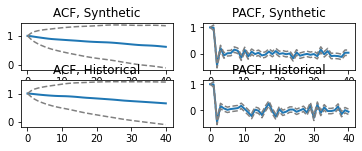

In [99]:
# %% compare ACF/PACF in synthetic
from statsmodels.tsa import stattools

plt.subplot(4,2,1)
acf,ci = stattools.acf(dailyQResampled[0], alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Synthetic')

plt.subplot(4,2,2)
pacf,ci = stattools.pacf(dailyQResampled[0], alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Synthetic')

plt.subplot(4,2,3)
acf,ci = stattools.acf(dailyQMatrix[0], alpha=0.05)
plt.plot(acf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('ACF, Historical')

plt.subplot(4,2,4)
pacf,ci = stattools.pacf(dailyQMatrix[0], alpha=0.05)
plt.plot(pacf, linewidth=2)
plt.plot(ci, linestyle='dashed', color='0.5')
plt.title('PACF, Historical')

## Multiple Realizations - KNN Analysis

In [100]:
# %% Use Thomas Fiering to simulate an annual flow time series based on historical annual flow
# 1 realization
# assuming a normal distribution, no data transformation
annQsyn_10 = thomasfiering(Wilkins_annQ, T=200, N=10)
annQsyn_100 = thomasfiering(Wilkins_annQ, T=200, N=100)
annQsyn_1000 = thomasfiering(Wilkins_annQ, T=200, N=1000)
annQsyn_10000 = thomasfiering(Wilkins_annQ, T=200, N=10000)

/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/natram3/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


In [251]:
def multi_realization_KNN(Q_gen, Wilkins_annQ, P):
    list_min = []
    list_mean = []
    list_high = []
    list_highest = []
    FlowsArrays = []
    test_rr2 = []
    
    for realizations in range(len(Q_gen)):
        # %% Resample using k nearest neighbors
        # Get number of years in synthetic series
        yearlyQ = Q_gen[realizations]
        N_yrs = len(yearlyQ)
        # Choose K as sqrt of N following Lall and Sharma 1996
        k = np.int(np.sqrt(N_yrs))

        # Initialize
        dailyQResampled_yrs = np.zeros([N_yrs, 365])

        for i in range(N_yrs):

            # For the current synthetic value, find the indicies of the
            # k nearest neighbors in the historical record
            kNN_ind = np.argsort(np.abs(yearlyQ[i] - Wilkins_annQ))[0:k]

            # Calculate the weights and check they sum to 1
            W = [(1/i) / np.sum(1 / np.arange(1,k+1)) for i in np.arange(1,k+1)]
            assert round(np.sum(W), 3) == 1.0, 'weights should sum to about 1'

            # Sample a year from historical record with weights W
            cumW = np.cumsum(W)
            rnd = np.random.rand()
            samp_ind = kNN_ind[np.where(rnd < cumW)[0][0]]

            # Get daily proportion series from sampled year and use to disaggregate
            # annual synthetic flow to daily flow
            dailyQResampled_yrs[i,:] = yearlyQ[i] * P[samp_ind, :] * 365
            
        df_dailyQResampled_yrs = pd.DataFrame({'Daily_Flows_by_Year':list(dailyQResampled_yrs)})
        test_rr2.append(df_dailyQResampled_yrs)
        years_syn = np.arange(len(Q_gen[realizations]))
      

        Min10DayFlow = []
        Yearly_Daily_Flows =[]
        TenDayFlow = []

        # compute annual min 10-day flows for 15 March (74th day) to 15 June (166th)
        for year in years_syn:
            Yearly_Daily_Flows = df_dailyQResampled_yrs['Daily_Flows_by_Year'][year]
            for s in range(len(Yearly_Daily_Flows)):
                if s > 79 and s < 171:
                    TenDayFlow_calc = sum(Yearly_Daily_Flows[s-11:s+1])
                    TenDayFlow.append(TenDayFlow_calc) 
            Min10DayFlow.append(min(TenDayFlow))
            TenDayFlow = [] # reset list to ensure min of each year, not of multiple years
 
        Min10DayFlowSyn_R_Array = np.array(Min10DayFlow)
    
        FlowsArrays.append(Min10DayFlowSyn_R_Array)
        numNotMet_min, numAbove_min, T = threshold_freq(Min10DayFlowSyn_R_Array, 0, threshold_min,0, droughtLen)
        numNotMet_mean,numAbove_mean, T = threshold_freq(Min10DayFlowSyn_R_Array, threshold_min, threshold_mean,0, droughtLen)
        numNotMet_high,numAbove_high, T = threshold_freq(Min10DayFlowSyn_R_Array, threshold_mean, threshold_high,0, droughtLen)
        numNotMet_highest,numAbove_highest, T = threshold_freq(Min10DayFlowSyn_R_Array, 0, 0, threshold_high, droughtLen)
        list_min.append(numNotMet_min)
        list_mean.append(numNotMet_mean)
        list_high.append(numNotMet_high)
        list_highest.append(numAbove_highest)
        df_dailyQResampled_yrs.iloc[0:0]

    return list_min, list_mean, list_high, list_highest, FlowsArrays, test_rr2

In [252]:
list_min_10, list_mean_10, list_high_10,list_highest_10, FlowsArrays_10, test_rr2 = multi_realization_KNN(annQsyn_10, Wilkins_annQ, P)

<ipython-input-251-1013cf3b693e>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N_yrs))


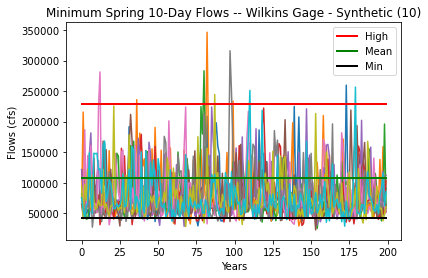

In [332]:
# Syn 10Q10 Plot
plt.figure()
plt.plot(years_syn, FlowsArrays_10[0])
plt.plot(years_syn, FlowsArrays_10[1])
plt.plot(years_syn, FlowsArrays_10[2])
plt.plot(years_syn, FlowsArrays_10[3])
plt.plot(years_syn, FlowsArrays_10[4])
plt.plot(years_syn, FlowsArrays_10[5])
plt.plot(years_syn, FlowsArrays_10[6])
plt.plot(years_syn, FlowsArrays_10[7])
plt.plot(years_syn, FlowsArrays_10[8])
plt.plot(years_syn, FlowsArrays_10[9])
plt.title('Minimum Spring 10-Day Flows -- Wilkins Gage - Synthetic (10)')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.plot([min(years_syn),max(years_syn)], [threshold_high, threshold_high], 'r-', lw=2, label = 'High')
plt.plot([min(years_syn),max(years_syn)], [threshold_mean, threshold_mean], 'g-', lw=2, label = 'Mean')
plt.plot([min(years_syn),max(years_syn)], [threshold_min, threshold_min], 'k-', lw=2, label = 'Min')
plt.legend()
plt.show()

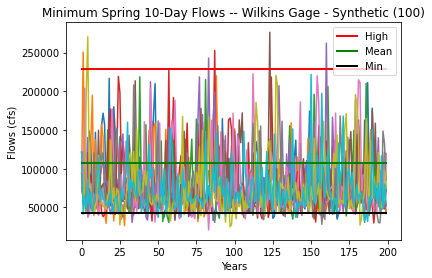

In [329]:
# Syn 10Q10 Plot
plt.figure()
plt.plot(years_syn, FlowsArrays_100[0])
plt.plot(years_syn, FlowsArrays_100[1])
plt.plot(years_syn, FlowsArrays_100[2])
plt.plot(years_syn, FlowsArrays_100[3])
plt.plot(years_syn, FlowsArrays_100[4])
plt.plot(years_syn, FlowsArrays_100[5])
plt.plot(years_syn, FlowsArrays_100[6])
plt.plot(years_syn, FlowsArrays_100[7])
plt.plot(years_syn, FlowsArrays_100[8])
plt.plot(years_syn, FlowsArrays_100[9])
plt.title('Minimum Spring 10-Day Flows -- Wilkins Gage - Synthetic (100)')
plt.xlabel('Years')
plt.ylabel('Flows (cfs)')
plt.plot([min(years_syn),max(years_syn)], [threshold_high, threshold_high], 'r-', lw=2, label = 'High')
plt.plot([min(years_syn),max(years_syn)], [threshold_mean, threshold_mean], 'g-', lw=2, label = 'Mean')
plt.plot([min(years_syn),max(years_syn)], [threshold_min, threshold_min], 'k-', lw=2, label = 'Min')
plt.legend()
plt.show()

In [254]:
list_min_100, list_mean_100, list_high_100,list_highest_100, FlowsArrays_100, test_rr2_100 = multi_realization_KNN(annQsyn_100, Wilkins_annQ, P)

<ipython-input-251-1013cf3b693e>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N_yrs))


In [195]:
list_min_1000, list_mean_1000, list_high_1000,list_highest_1000, test_rr1000, test_rr2_1000 = multi_realization_KNN(annQsyn_1000, Wilkins_annQ, P)

<ipython-input-193-6ed86fc7ef51>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N_yrs))


In [196]:
list_min_10000, list_mean_10000, list_high_10000,list_highest_10000, test_rr10000, test_rr2_10000 = multi_realization_KNN(annQsyn_10000, Wilkins_annQ, P)

<ipython-input-193-6ed86fc7ef51>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k = np.int(np.sqrt(N_yrs))


In [201]:
std_10_min = np.std(list_min_10)/len(annQsyn_100[0])
std_100_min = np.std(list_min_100)/len(annQsyn_100[0])
std_1000_min = np.std(list_min_1000)/len(annQsyn_1000[0])
std_10000_min = np.std(list_min_10000)/len(annQsyn_10000[0])
errors_min = [0,0,std_10_min,std_100_min,std_1000_min,std_10000_min]

std_10_mean = np.std(list_mean_10)/len(annQsyn_10[0])
std_100_mean = np.std(list_mean_100)/len(annQsyn_100[0])
std_1000_mean = np.std(list_mean_1000)/len(annQsyn_1000[0])
std_10000_mean = np.std(list_mean_10000)/len(annQsyn_10000[0])
errors_mean = [0,0,std_10_mean,std_100_mean,std_1000_mean,std_10000_mean]

std_10_high = np.std(list_high_10)/len(annQsyn_10[0])
std_100_high = np.std(list_high_100)/len(annQsyn_100[0])
std_1000_high  = np.std(list_high_1000)/len(annQsyn_1000[0])
std_10000_high  = np.std(list_high_10000)/len(annQsyn_10000[0])
errors_high  = [0,0,std_10_high ,std_100_high ,std_1000_high ,std_10000_high ]


std_10_highest = np.std(list_highest_10)/len(annQsyn_10[0])
std_100_highest = np.std(list_highest_100)/len(annQsyn_100[0])
std_1000_highest  = np.std(list_highest_1000)/len(annQsyn_1000[0])
std_10000_highest  = np.std(list_highest_10000)/len(annQsyn_10000[0])
errors_highest  = [0,0,std_10_highest ,std_100_highest ,std_1000_highest ,std_10000_highest ]

In [238]:
df_results = pd.DataFrame(data = [numNotMet_min,numNotMet_mean,numNotMet_high,numAbove], columns=['Historical']) # (Occurence per Year)
df_results['Historical'] = df_results['Historical']/len(years)

df_results['1'] = [numNotMet_min_syn_1,numNotMet_mean_syn_1,numNotMet_high_syn_1,numAbove_syn_1]
df_results['10'] = [np.mean(list_min_10),np.mean(list_mean_10),np.mean(list_high_10),np.mean(list_highest_10)]
df_results['100'] = [np.mean(list_min_100),np.mean(list_mean_100),np.mean(list_high_100),np.mean(list_highest_100)]
df_results['1000'] = [np.mean(list_min_1000),np.mean(list_mean_1000),np.mean(list_high_1000),np.mean(list_highest_1000)]
df_results['10000'] = [np.mean(list_min_10000),np.mean(list_mean_10000),np.mean(list_high_10000),np.mean(list_highest_10000)]

df_results['1'] = df_results['1']/len(annQsyn_1)
df_results['10'] = df_results['10']/len(annQsyn_10[0])
df_results['100'] = df_results['100']/len(annQsyn_100[0])
df_results['1000'] = df_results['1000']/len(annQsyn_1000[0])
df_results['10000'] = df_results['10000']/len(annQsyn_10000[0])

df_results['Survivability %'] = [.03, .189, .508,.353]
df_results['Flow'] = ['Min','Mean','High','Above High']

df_results.set_index('Flow',inplace=True)


In [359]:
df_results

,Historical,1,10,100,1000,10000,Survivability %
Flow,,,,,,,
Min,0.086420,0.045,0.0650,0.0683,0.068705,0.068095,0.030
Mean,0.740741,0.755,0.7700,0.7553,0.762445,0.763410,0.189
High,0.172840,0.200,0.1585,0.1715,0.164180,0.163692,0.508
Above High,0.000000,0.000,0.0065,0.0049,0.004670,0.004803,0.353


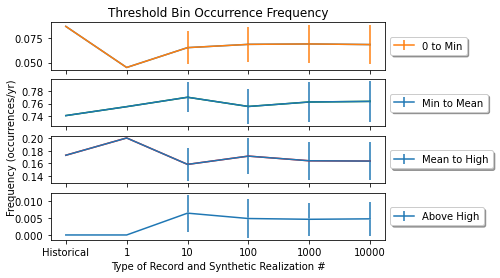

In [351]:
plt.figure()

ax1 = plt.subplot(411)

plt.plot(df_results.iloc[0][:-1])
plt.errorbar(['Historical','1','10','100','1000','10000'], df_results.iloc[0][:-1],errors_min, label = '0 to Min')
plt.legend(bbox_to_anchor=(1, .5), loc='center left', shadow = True)
plt.tick_params('x', labelbottom=False)
plt.title('Threshold Bin Occurrence Frequency')

ax2 = plt.subplot(412,sharex=ax1)
plt.plot(df_results.iloc[1][:-1], color = 'g')
plt.errorbar(['Historical','1','10','100','1000','10000'], df_results.iloc[1][:-1],errors_mean, label = 'Min to Mean')
plt.tick_params('x', labelbottom=False)
plt.ylabel('Frequency (occurrences/yr)',loc='top')
plt.yticks(np.arange(.74,.78,step=.02))
plt.legend(bbox_to_anchor=(1, .5), loc='center left', shadow = True)


ax3 = plt.subplot(413,sharex=ax1)
plt.plot(df_results.iloc[2][:-1], color = 'r')
plt.errorbar(['Historical','1','10','100','1000','10000'], df_results.iloc[2][:-1],errors_high, label = 'Mean to High')
plt.legend(bbox_to_anchor=(1, .5), loc='center left', shadow = True)
plt.yticks(np.arange(.14,.22,step=.02))

plt.tick_params('x', labelbottom=False)


ax4 = plt.subplot(414,sharex=ax1)
plt.plot(df_results.iloc[3][:-1], color = 'white')
plt.errorbar(['Historical','1','10','100','1000','10000'], df_results.iloc[3][:-1],errors_highest, capsize=0,label = 'Above High')
plt.xlabel('Type of Record and Synthetic Realization #')
plt.yticks(np.arange(min(df_results.iloc[3][:-1]),.015,step=.005))
plt.legend(bbox_to_anchor=(1, .5), loc='center left', shadow = True)
plt.tick_params('x', labelsize=10)


# plt.tight_layout()
